# Reconstruction of cellpainting image using ML

This notebook aims at reconstructing multichannel cellpating image using ML. We first load some packages

In [1]:
import torchvision
from torchvision.transforms import v2
import torch
import os
import sys
import numpy as np 
import lightning as L
import importlib
import shutil
from lightning.pytorch.utilities.model_summary import ModelSummary


# We add the correct path to the system
PATH_SCRIPTS = [
    "../",
    os.path.join(
        os.path.dirname(os.getcwd()),
        "src","gencellpainting"),
    os.path.join(
        os.path.dirname(os.getcwd()),
        "src","gencellpainting","model")        
    ]
sys.path.extend(PATH_SCRIPTS)

import gencellpainting as gc


# from gencellpainting.mdataset import CellPaintingDatasetInMemory,WGANCriticDataset
from gencellpainting.mdataset import CellPaintingDatasetInMemory,WGANCriticDataset

/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We define a folder to store the trained models

In [2]:
PATH_MODELS = os.path.abspath(os.path.join("../../","data","models"))

The data as already been preprocessed into tensor of dimension C, H, W where:
* __C__ is the rnumber of channel: in this case 5
* __H__ is the heigth of the image
* __W__ is the wifdth of the image

And is stored in the folder:

In [3]:
PATH_IMAGES = "/mnt/c/Users/alexi/Documents/data/images/cellpainting/cpg0016-jump/data/resized_tensor_128_uint8"

A torch Dataset class havbe already been written for convenience, to speed up the test all thew data is stored in memory. To isnpect the data first, we will load the image

In [4]:
ds10 = CellPaintingDatasetInMemory(root=PATH_IMAGES,n_images=10)

100%|██████████| 10/10 [00:00<00:00, 51.25it/s]


We can first inspect the images

In [5]:
image = ds10[5]
image_dim = image.shape
C,H,W = image_dim
print(image_dim)

torch.Size([5, 128, 128])


Cell painting data are composed of multiples channels showing the different fluorophores showing different componnents. In this case for memory purpose the imaghes have 5 channels and have been resized to 128x128 pixels.

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'


# Visualization fucntion take from  https://docs.pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [7]:
def plot_cellpainting_image(image, nrow=3):
    imgs = list(torch.split(image,1,dim=0))
    print([x.shape for x in imgs])
    grid = torchvision.utils.make_grid(imgs,nrow = nrow)
    show(grid)
    

[torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128])]


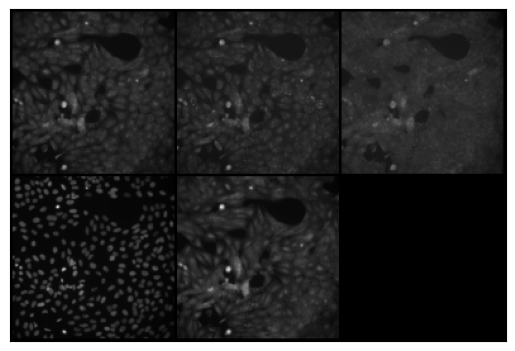

In [8]:
plot_cellpainting_image(image)

In order to diversify the amount of image, we add a set of transformations

In [ ]:
transforms = v2.Compose([
    #v2.RandomRotation(degrees=(0, 180)),
    v2.ToDtype(torch.float32, scale=True) # This also set the values of the tensor between 0 and 1
])

In [32]:
transforms.__class__

torchvision.transforms.v2._container.Compose

[torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128])]


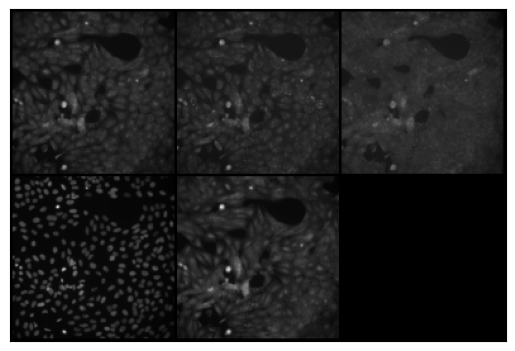

In [10]:
timg = transforms(image)
plot_cellpainting_image(timg)

We ca now load the full dataset in memory with our newly defined transforms, for testinmg purpose we split into 2 datasets, opne for training and one for validation.

In [11]:
test_frac = 0.2
paths = [x for x in os.listdir(PATH_IMAGES) if x.endswith(".pt")]

paths_train = np.random.choice(paths,size=int(len(paths)*(1-test_frac)),replace=False)
paths_test = [x for x in paths if x not in paths_train]

print("THere is {} training images and {} test images".format(len(paths_train),len(paths_test)))

THere is 5544 training images and 1386 test images


In [12]:
ds_train = CellPaintingDatasetInMemory(root=PATH_IMAGES,transform=transforms, paths=paths_train)
ds_test = CellPaintingDatasetInMemory(root=PATH_IMAGES,transform=transforms, paths=paths_test)

100%|██████████| 1386/1386 [01:02<00:00, 22.13it/s]


No in order to perform the learning we need to create batches, this can be performed using a dataloader.

In [13]:
BATCH_SIZE = 64

In [14]:
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)

We extract some constants to parametrize the NNs

In [15]:
B, C, W, _ = next(iter(dl_test)).size()

In this case we allow the shulffing of the data as they are all in memory and the order in which we fetch the data should nbot affect the loading speed.

### Logging

We log the image generation using tensorboard for image generation

In [16]:
PATH_LOGS = os.path.join(os.getcwd(),"log_tensorboard")

In [17]:
if os.path.exists(PATH_LOGS):
    shutil.rmtree(PATH_LOGS)

print("Logging for tensorboard in '{}'".format(PATH_LOGS))

Logging for tensorboard in '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/notebooks/log_tensorboard'


# Generating images

## VAE 
A reliable baseline module is the VAE, so we first use that

In [18]:
# TO quickly reload
import gencellpainting.model.VAE as VAE
VAE = importlib.reload(VAE)

We add the data

In [21]:
mVAE = VAE.VAE(latent_dim=512, in_channels=ds_test.n_channels, out_channels=ds_test.n_channels,\
               epoch_monitoring_interval=1, n_images_monitoring=3, alpha = 0.01, learning_rate=5e-4,\
                  network_capacity=16, image_size=W)

In [22]:
ModelSummary(mVAE)

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | encoder | EncoderWithPooling | 8.5 M  | train
1 | decoder | Decoder            | 7.0 M  | train
-------------------------------------------------------
15.5 M    Trainable params
0         Non-trainable params
15.5 M    Total params
61.908    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode

We configure the trainer, with an early stopping case

In [23]:
NAME_MODEL = "VAE"
plogs = os.path.join(PATH_LOGS,NAME_MODEL)
if os.path.isdir(plogs):
    shutil.rmtree(plogs)
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name=NAME_MODEL)


In [24]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
early_stopping = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", mode="min", patience=3)
trainer = L.Trainer(max_epochs=100, accelerator="gpu", devices=1, logger=tb_logger, callbacks=[early_stopping])

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(mVAE, train_dataloaders=dl_train, val_dataloaders=dl_test)

You are using a CUDA device ('NVIDIA RTX 2000 Ada Generation Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | encoder | EncoderWithPooling | 8.5 M  | train
1 | decoder | Decoder            | 7.0 M  | train
-------------------------------------------------------
15.5 M    Trainable params
0         Non-trainable params
15.5 M    Total params
61.908    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


Epoch 6:  28%|██▊       | 24/87 [00:02<00:06,  9.85it/s, v_num=0, train_mse_step=0.004, train_kl_step=1.14e+4, total_loss_step=114.0, val_loss=0.00401, train_mse_epoch=0.00403, train_kl_epoch=1.38e+4, total_loss_epoch=138.0]  


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [29]:
float(trainer.logged_metrics["val_loss"])

0.004010885022580624

In [58]:
L.pytorch.utilities.model_summary.ModelSummary(mVAE)

  | Name                  | Type                | Params | Mode 
----------------------------------------------------------------------
0 | clip_frechet_distance | FrechetCLIPDistance | 151 M  | train
1 | encoder               | EncoderWithPooling  | 17.2 M | train
2 | decoder               | Decoder             | 5.4 M  | train
----------------------------------------------------------------------
22.6 M    Trainable params
151 M     Non-trainable params
173 M     Total params
695.489   Total estimated model params size (MB)
51        Modules in train mode
307       Modules in eval mode

In [47]:
b1 = ds_test[100]
b1 = b1.unsqueeze(0)
b1.shape

torch.Size([1, 5, 128, 128])

In [33]:
y1 = mVAE.decoder(mVAE.encoder(b1).sample())

[torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128])]


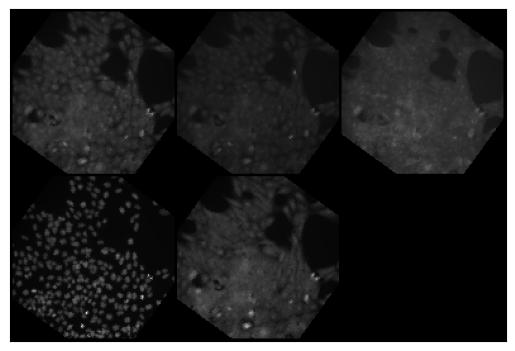

In [34]:
plot_cellpainting_image(b1.squeeze())

[torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128]), torch.Size([1, 128, 128])]


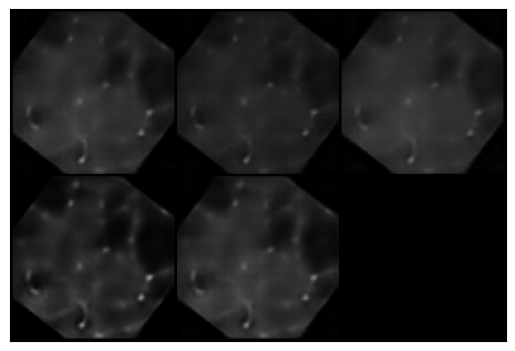

In [35]:
plot_cellpainting_image(y1.squeeze())

## Generative Adversarial Network (GAN)


In [48]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [59]:
import gencellpainting.model.GAN as GAN
GAN = importlib.reload(GAN)

Defining the logger

In [60]:
mGAN = GAN.GAN(generator=None,discriminator=None,in_channels=ds_train.n_channels,out_channels=ds_train.n_channels,noise_dim=512, learning_rate=1e-5)


We can similary ltrain the model

In [61]:
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name="GAN")
gan_trainer = L.Trainer(max_epochs=30, accelerator="gpu", devices=1, logger=tb_logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [62]:
gan_trainer.fit(mGAN, train_dataloaders=dl_train)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                | Params | Mode 
----------------------------------------------------------------------
0 | clip_frechet_distance | FrechetCLIPDistance | 151 M  | train
1 | precision             | BinaryPrecision     | 0      | train
2 | recall                | BinaryRecall        | 0      | train
3 | generator             | Decoder             | 5.4 M  | train
4 | discriminator         | Discriminator       | 257 K  | train
----------------------------------------------------------------------
5.7 M     Trainable params
151 M     Non-trainable params
156 M     Total params
627.786   Total estimated model params size (MB)
53        Modules in train mode
307       Modules in eval mode


Epoch 0:  59%|█████▊    | 102/174 [00:11<00:08,  8.91it/s, v_num=4, loss_d=0.145, loss_g=2.780, loss_d_real=0.0741, loss_d_fake=0.0709]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

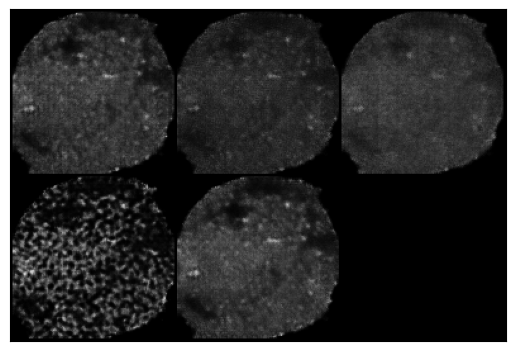

In [164]:
# Sampling an image for demonstration
y1_gan = mGAN.generator(mGAN.sample_z(1))
plot_cellpainting_image(y1_gan.squeeze())

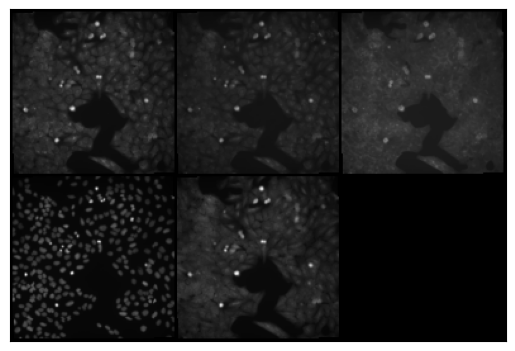

In [72]:
# Plotting a real image
plot_cellpainting_image(b1.squeeze())

While the image looks fine from afar, we clearly see some limitation, too dense nuclei frame (4th) image and checkerboard patterns.

### Wasserstein GAN

The Wasserstein GAN are a more stable version of GAN, and to be frank I am just curious of their performance.

In [216]:
NCRITICS = 5

In [217]:
ds_train_W = WGANCriticDataset(ds_train,ncritic=NCRITICS)
ds_test_W = WGANCriticDataset(ds_test,ncritic=NCRITICS)

In order for the dataloader to know how to stitch a batch together we put everything together the `collate_fn` argument

In [218]:
# This funciton will retirn aa tuple with 2 elements
# 1. The images to process with the generator (B x C x H x W)
# 2. The images to process with the discirminator for learning ( (B x NCRITIC) x C x H x W) 
def collate_wgan_batch(batch):
    gen_imgs,disc_imgs = zip(*batch)
    gen_imgs = torch.stack(gen_imgs)
    disc_imgs = torch.stack([y for subbatch in disc_imgs for y in subbatch ])
    return gen_imgs, disc_imgs

In [219]:
dl_train_W = torch.utils.data.DataLoader(ds_train_W,batch_size=32,shuffle=True, collate_fn=collate_wgan_batch, num_workers=4)
dl_test_W = torch.utils.data.DataLoader(ds_test_W,batch_size=32,shuffle=True, collate_fn=collate_wgan_batch, num_workers=4)

We define the logging folders

In [220]:
tbatch = next(iter(dl_train_W))
train_real,train_disc = tbatch

We can now test the model

In [221]:
import gencellpainting.model.WGAN as WGAN
importlib.reload(WGAN)

<module 'gencellpainting.model.WGAN' from '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/notebooks/../gencellpainting/model/WGAN.py'>

In [222]:
wgan = WGAN.WGAN_GP(in_channels=ds_train.n_channels,out_channels=ds_train.n_channels,noise_dim=256,n_critic=NCRITICS, learning_rate = 2e-5, image_size=128,vlambda=20)

Epoch 9: 100%|██████████| 94/94 [29:46<00:00,  0.05it/s, v_num=8, G_loss=-0.00354, C_loss=0.360, d_C_loss=0.00183, d_G_loss=0.00356, GradPen=0.0351]


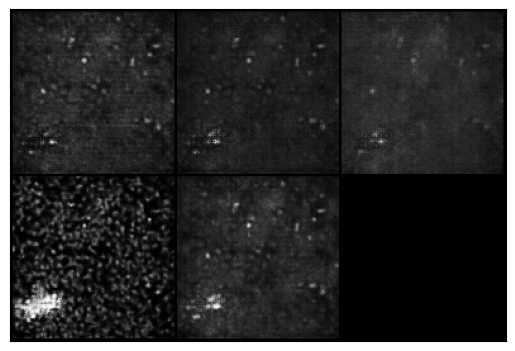

In [232]:
timages = wgan.generate_images(n=2,batch=torch.rand(1))
plot_cellpainting_image(timages[0])

In [224]:
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name="WGAN_GP")
trainer_wg = L.Trainer(max_epochs=100,accelerator="gpu",devices=1, logger=tb_logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [225]:
trainer_wg.fit(wgan,dl_train_W)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                | Params | Mode 
----------------------------------------------------------------------
0 | clip_frechet_distance | FrechetCLIPDistance | 151 M  | train
1 | precision             | BinaryPrecision     | 0      | train
2 | recall                | BinaryRecall        | 0      | train
3 | generator             | Decoder             | 4.9 M  | train
4 | discriminator         | WGANCritic          | 2.8 M  | train
----------------------------------------------------------------------
7.7 M     Trainable params
151 M     Non-trainable params
158 M     Total params
635.857   Total estimated model params size (MB)
46        Modules in train mode
307       Modules in eval mode


Epoch 99: 100%|██████████| 174/174 [01:10<00:00,  2.46it/s, v_num=1, G_loss=6.710, C_loss=2.950, d_C_loss=-4.54, d_G_loss=-6.45, GradPen=0.324]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 174/174 [01:14<00:00,  2.35it/s, v_num=1, G_loss=6.710, C_loss=2.950, d_C_loss=-4.54, d_G_loss=-6.45, GradPen=0.324]


In [235]:
PATH_MODELS

'/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/data/models'

In [246]:
trainer_wg.save_checkpoint(os.path.join(PATH_MODELS,"WGAN_GP"))

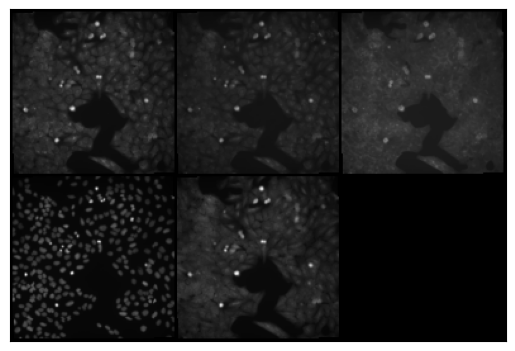

In [ ]:
plot_cellpainting_image(b1.squeeze())

### MNIST dbebugging

In [134]:
from torchvision.datasets import MNIST
transform_mnist = v2.Compose([
    v2.Resize((32,32)),
    v2.ToDtype(torch.float32, scale=True),# This also set the values of the tensor between 0 and 1
    v2.ToTensor()
])
mnist = MNIST(root="/mnt/c/Users/alexi/Documents/data/images/mnist",train=True,download=True,transform=transform_mnist)

/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [208]:
import gencellpainting.model.WGAN as WGAN
importlib.reload(WGAN)

<module 'gencellpainting.model.WGAN' from '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/notebooks/../gencellpainting/model/WGAN.py'>

In [209]:
class WGANCriticMNIST(torchvision.datasets.VisionDataset):
    def __init__(self, dataset, ncritic):
        self.root = "root"
        self.dataset = dataset
        self.ncritic = ncritic
        self.n_samples = min(6000,len(dataset))

    def process_image(self, x):
        return x[0]

    def __getitem__(self, index):
        # Random samping of ncritic intex
        random_idx = torch.randint(0, self.n_samples, (self.ncritic,))
        items = [self.process_image(self.dataset[i]) for i in random_idx]
        return self.process_image(self.dataset[index]),items
    
    def __len__(self):
        return self.n_samples


In [210]:
ds_mnist = WGANCriticMNIST(mnist,ncritic=5)
dl_wgan_mnist = torch.utils.data.DataLoader(ds_mnist, batch_size=64, shuffle=True, collate_fn=collate_wgan_batch, num_workers=4)

In [211]:
batch = next(iter(dl_wgan_mnist))

We train tyhe wgan to debug

In [212]:
wgan_mnist = WGAN.WGAN_GP(in_channels=1,out_channels=1,noise_dim=64,image_size=32,n_critic=NCRITICS, learning_rate = 2e-5, vlambda=10)

In [178]:
wgan_mnist.discriminator.network_channels

[32, 64, 128, 256]

In [213]:
tz = wgan_mnist.sample_z(10)
with torch.no_grad():
    gz = wgan_mnist.generator(tz)
wgan_mnist.discriminator(gz).shape

torch.Size([10, 1, 1, 1])

In [214]:
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name="WGAN_MNIST")
trainer_mnist = L.Trainer(max_epochs=50,accelerator="gpu",devices=1, logger=tb_logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [215]:
trainer_mnist.fit(wgan_mnist,dl_wgan_mnist)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                | Params | Mode 
----------------------------------------------------------------------
0 | clip_frechet_distance | FrechetCLIPDistance | 151 M  | train
1 | precision             | BinaryPrecision     | 0      | train
2 | recall                | BinaryRecall        | 0      | train
3 | generator             | Decoder             | 296 K  | train
4 | discriminator         | WGANCritic          | 167 K  | train
----------------------------------------------------------------------
463 K     Trainable params
151 M     Non-trainable params
151 M     Total params
606.962   Total estimated model params size (MB)
32        Modules in train mode
307       Modules in eval mode


Epoch 49: 100%|██████████| 94/94 [00:10<00:00,  8.92it/s, v_num=9, G_loss=6.890, C_loss=0.948, d_C_loss=-4.23, d_G_loss=-6.67, GradPen=0.299]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 94/94 [00:13<00:00,  6.88it/s, v_num=9, G_loss=6.890, C_loss=0.948, d_C_loss=-4.23, d_G_loss=-6.67, GradPen=0.299]


### Diffusion based model

This section presents the diffusion training process

In [71]:
import gencellpainting.model.net.UNETdiffusion as UND
importlib.reload(UND)
import gencellpainting.model.diffusion as DIF
importlib.reload(DIF)

<module 'gencellpainting.model.diffusion' from '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/notebooks/../gencellpainting/model/diffusion.py'>

In [69]:
TIME_CHANNELS = 32
NSTEPS = 200

We can now create the diffusion process using the UNET created

In [70]:
unet_diff = UND.UNetDiffusion(ds_train.n_channels, ds_train.n_channels, time_channels = TIME_CHANNELS, network_capacity=32, nlayers=3)
# unet_diff = unet_diff
diffusion = DIF.DiffusionProcess(ds_train.n_channels,time_dim=TIME_CHANNELS,nsteps=NSTEPS,model=unet_diff)
# diffusion = diffusion.to("cuda")

NameError: name 'ds_train' is not defined

In [21]:
from lightning.pytorch.utilities.model_summary import ModelSummary

In [22]:
ModelSummary(diffusion)

  | Name       | Type                           | Params | Mode 
----------------------------------------------------------------------
0 | model      | UNetDiffusion                  | 861 K  | train
1 | time_model | TransformerPositionalEmbedding | 0      | train
----------------------------------------------------------------------
861 K     Trainable params
0         Non-trainable params
861 K     Total params
3.445     Total estimated model params size (MB)
83        Modules in train mode
0         Modules in eval mode

We need to train the model

In [ ]:

NAME_MODEL = "DIFF_UNET"
plogs = os.path.join(PATH_LOGS,NAME_MODEL)
if os.path.isdir(plogs):
    shutil.rmtree(plogs)
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name=NAME_MODEL)

trainer_diff = L.Trainer(max_epochs=10,accelerator="gpu",devices=1, logger=tb_logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [24]:
trainer_diff.fit(diffusion,dl_train)

NameError: name 'dl_train' is not defined

### Debugging diffusion model

In [13]:
from torchvision.datasets import MNIST
transform_mnist = v2.Compose([
    v2.Resize((32,32)),
    v2.ToDtype(torch.float32, scale=True),# This also set the values of the tensor between 0 and 1
    v2.ToTensor()
])
def collate_fn_mnist(batch):
    batch = torch.cat([x[0] for x in batch])
    batch = ( batch - 0.5 ) * 2
    return batch[:,None,:,:]
ds_mnist = MNIST(root="/mnt/c/Users/alexi/Documents/data/images/mnist",train=True,download=True,transform=transform_mnist)
ds_mnist_subset = torch.utils.data.Subset(ds_mnist,range(5000))
dl_mnist = torch.utils.data.DataLoader(ds_mnist_subset,batch_size = 64, collate_fn=collate_fn_mnist)

/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [14]:
bab = next(iter(dl_mnist))

We create the simplest diffusion model

In [70]:
import gencellpainting.model.net.UNETdiffusion as UND
importlib.reload(UND)
import gencellpainting.model.diffusion as DIF
importlib.reload(DIF)

<module 'gencellpainting.model.diffusion' from '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/notebooks/../gencellpainting/model/diffusion.py'>

In [58]:
TIME_CHANNELS = 64
NSTEPS = 200
NETWORK_CHANNEL = 32
NLAYERS = 3
unet_diff = UND.UNetDiffusion(1, 1, time_channels = TIME_CHANNELS, network_capacity=NETWORK_CHANNEL,\
                               nlayers=NLAYERS, activation="none")
# unet_diff = unet_diff
diffusion = DIF.DiffusionProcess(1,time_dim=TIME_CHANNELS,nsteps=NSTEPS,\
                                 model=unet_diff, learning_rate=1e-4)
# diffusion = diffusion.to("cuda")

In [59]:
diffusion.alphas[:10],diffusion.cum_alphas[:10]

(tensor([0.9999, 0.9998, 0.9997, 0.9996, 0.9995, 0.9994, 0.9993, 0.9992, 0.9991,
         0.9990]),
 tensor([0.9999, 0.9997, 0.9994, 0.9990, 0.9985, 0.9979, 0.9972, 0.9964, 0.9955,
         0.9945]))

Checking the ffect of the noise

In [61]:
def get_imgs(ds, idx):
    imgs = [ds[ix][0] for ix in idx]
    imgs = torch.cat(imgs,axis=0)
    imgs = (imgs-0.5)*2
    return imgs

vimg = get_imgs(ds_mnist,[300])

In [62]:
gvimgs = vimg[:,None,:,:]
tsteps = [(x+1)*10-1 for x in range(20)]
gvimgs = gvimgs.expand(len(tsteps),-1,-1,-1)
gnoise = diffusion.gaussian_noise(gvimgs)

with torch.no_grad():
    gvimgs_noised = diffusion.q_sample(gvimgs,gnoise,[(x+1)*10-1 for x in range(20)])

[torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1, 32, 32])]

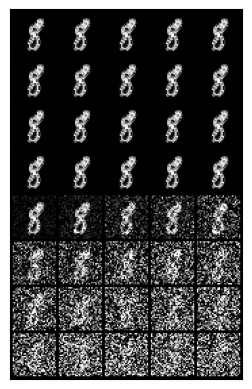

In [63]:

timgs_tensor = torch.clamp(torch.cat([gvimgs,gvimgs_noised], dim=0),min=-1.,max=1.)
timgs_tensor = timgs_tensor.squeeze()
# plot_cellpainting_image(torch.clamp(timgs_tensor[:,:5,:5],min=-1.,max=1.),nrow=5)
plot_cellpainting_image(torch.clamp(timgs_tensor,min=-1.,max=1.),nrow=5)

In [64]:
gvimgs_noised[0,0,:5,:5]

tensor([[-0.8690, -1.0234, -1.1097, -0.8937, -1.0644],
        [-0.8467, -0.7677, -0.9659, -0.9006, -1.1972],
        [-0.8723, -1.0472, -1.0179, -1.0892, -1.0390],
        [-0.9133, -0.9562, -0.9453, -0.9173, -0.9406],
        [-0.9900, -0.8093, -0.9332, -1.0361, -1.0728]])

In [65]:

NAME_MODEL = "DIFF_UNET_MNIST"
PATH_LOGS = os.path.join(os.getcwd(),"log_tensorboard")

plogs = os.path.join(PATH_LOGS,NAME_MODEL)
if os.path.isdir(plogs):
    shutil.rmtree(plogs)
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name=NAME_MODEL)

trainer_diff_mnist = L.Trainer(max_epochs=100,accelerator="gpu",devices=1, logger=tb_logger)
trainer_diff_mnist.fit(diffusion,dl_mnist)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                           | Params | Mode 
----------------------------------------------------------------------
0 | loss       | SmoothL1Loss                   | 0      | train
1 | model      | UNetDiffusion                  | 874 K  | train
2 | time_model | TransformerPositionalEmbedding | 0      | train
----------------------------------------------------------------------
874 K     Trainable params
0         Non-trainable params
874 K     Total params
3.497     Total estimated model params size (MB)
85        Modules in train mode
0         Modules in eval mode
/home/adelabriere/miniconda3/envs/imaging/lib/python3.12/site-packages/lightning/pytorch

Epoch 12:  14%|█▍        | 11/79 [09:29<58:41,  0.02it/s, v_num=0]
Monitored batch range -1.0-1.0 gen range -0.0035408888943493366-0.018369052559137344
Epoch 75:   3%|▎         | 2/79 [00:00<00:34,  2.24it/s, v_num=0]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

Test with another implementation

In [89]:
import gencellpainting.model.dbugdiff as DBUGDIFF
importlib.reload(DBUGDIFF)
import gencellpainting.model.net.UNETdiffusion as UND
importlib.reload(UND)
import gencellpainting.model.diffusion as DIF
importlib.reload(DIF)

<module 'gencellpainting.model.diffusion' from '/mnt/c/Users/alexi/Documents/dev/portfolio/imaging/segmentation/src/notebooks/../gencellpainting/model/diffusion.py'>

In [90]:
dbug_unet = DBUGDIFF.UnetDbug(dim = 32,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=1,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2
    )

diffusion = DIF.DiffusionProcess(1,time_dim=TIME_CHANNELS,nsteps=NSTEPS,\
                                 model=dbug_unet, learning_rate=1e-4, include_time_emb=False)

In [91]:

NAME_MODEL = "DIFF_UNETDBUG_MNIST"
PATH_LOGS = os.path.join(os.getcwd(),"log_tensorboard")

plogs = os.path.join(PATH_LOGS,NAME_MODEL)
if os.path.isdir(plogs):
    shutil.rmtree(plogs)
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name=NAME_MODEL)

trainer_diff_mnist = L.Trainer(max_epochs=100,accelerator="gpu",devices=1, logger=tb_logger)
trainer_diff_mnist.fit(diffusion,dl_mnist)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | loss  | SmoothL1Loss | 0      | train
1 | model | UnetDbug     | 14.7 M | train
-----------------------------------------------
14.7 M    Trainable params
0         Non-trainable params
14.7 M    Total params
58.916    Total estimated model params size (MB)
289       Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 79/79 [00:13<00:00,  5.69it/s, v_num=0]


In [ ]:
bab.shape

torch.Size([64, 1, 32, 32])

In [28]:
sim_time = diffusion.time_model(torch.arange(BATCH_SIZE)[:,None])
diffusion.model(bab,sim_time)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 64, 32, 32, 32]

In [48]:
img,i_imgs = diffusion.generate_images(n=1, return_intermediate=True)

[torch.Size([1, 128, 128])]


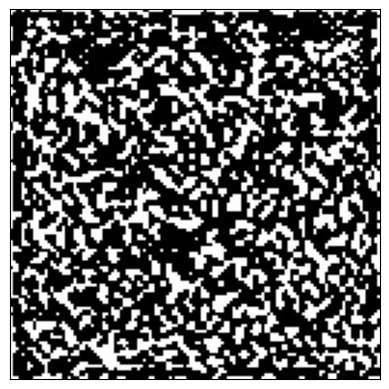

In [64]:
plot_cellpainting_image(i_imgs[19][0])

In [34]:
sidx = 15
i_imgs[sidx].min(),i_imgs[sidx].max()

(tensor(-0.2832), tensor(0.2768))

In [303]:
diffusion.betas

tensor([1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04,
        1.1104e-04, 1.2469e-04, 1.3858e-04, 1.5211e-04, 1.6594e-04, 1.7959e-04,
        1.9336e-04, 2.0707e-04, 2.2089e-04, 2.3443e-04, 2.4831e-04, 2.6196e-04,
        2.7585e-04, 2.8944e-04, 3.0315e-04, 3.1704e-04, 3.3081e-04, 3.4446e-04,
        3.5828e-04, 3.7205e-04, 3.8576e-04, 3.9959e-04, 4.1336e-04, 4.2719e-04,
        4.4096e-04, 4.5466e-04, 4.6861e-04, 4.8250e-04, 4.9621e-04, 5.0998e-04,
        5.2387e-04, 5.3769e-04, 5.5164e-04, 5.6541e-04, 5.7930e-04, 5.9313e-04,
        6.0701e-04, 6.2090e-04, 6.3479e-04, 6.4886e-04, 6.6262e-04, 6.7651e-04,
        6.9052e-04, 7.0435e-04, 7.1847e-04, 7.3230e-04, 7.4631e-04, 7.6032e-04,
        7.7426e-04, 7.8827e-04, 8.0234e-04, 8.1635e-04, 8.3029e-04, 8.4442e-04,
        8.5855e-04, 8.7249e-04, 8.8656e-04, 9.0069e-04, 9.1481e-04, 9.2906e-04,
        9.4301e-04, 9.5719e-04, 9.7144e-04, 9.8544e-04, 9.9975e-04, 1.0141e-03,
        1.0281e-03, 1.0424e-03, 1.0567e-

In [ ]:
unet_diff

Debugging the UNET, we debug the UNET by applying a simple autoencoder a verifying if the model manageo to learn something

In [37]:
import torch.nn as nn
class DebugUnet(gc.model.abc_model.UnsupervisedImageGenerator):
    def __init__(self, model, time_channels, epoch_monitoring_interval=1, n_images_monitoring=6):
        super(DebugUnet, self).__init__(epoch_monitoring_interval=epoch_monitoring_interval, n_images_monitoring=n_images_monitoring, add_original=True)
        self.model = model
        self.time_channels = time_channels
        self.loss = nn.MSELoss()

    def fake_time(self, batch):
        return torch.randn((batch.size(0),self.time_channels)).to(batch.device)

    def training_step(self, batch, batch_idx):
        x_hat = self.model(batch, self.fake_time(batch))
        super().training_step(batch, batch_idx)
        vloss = self.loss(x_hat, batch)
        self.log("MSE", vloss)
        return vloss
    
    def generate_images(self, batch=None, n=6):
        x_hat = self.model(batch,  self.fake_time(batch))
        return x_hat

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)    

In [40]:
TIME_CHANNELS = 16
NETWORK_CHANNEL = 8
NLAYERS = 3
unet_diff = UND.UNetDiffusion(1, 1, time_channels = TIME_CHANNELS, network_capacity=NETWORK_CHANNEL, nlayers=NLAYERS)
dunet = DebugUnet(model=unet_diff, time_channels=TIME_CHANNELS)

In [41]:

NAME_MODEL = "DBUG_UNET_MNIST"
PATH_LOGS = os.path.join(os.getcwd(),"log_tensorboard")

plogs = os.path.join(PATH_LOGS,NAME_MODEL)
if os.path.isdir(plogs):
    shutil.rmtree(plogs)
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name=NAME_MODEL)

trainer_dbug = L.Trainer(max_epochs=10,accelerator="gpu",devices=1, logger=tb_logger)
trainer_dbug.fit(dunet,dl_mnist)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | UNetDiffusion | 55.4 K | train
1 | loss  | MSELoss       | 0      | train
------------------------------------------------
55.4 K    Trainable params
0         Non-trainable params
55.4 K    Total params
0.221     Total estimated model params size (MB)
83        Modules in train mode
0         Modules in eval mode


Epoch 4:  13%|█▎        | 118/938 [00:02<00:20, 40.90it/s, v_num=0]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

### SimpleGAN2
SimpleGAN2 is a more complex GAN including feature from StyleGAN2, its main features are:
* __Style embedding:__ The noise vector is embedded into a disentangled space.
* __Progressive growth:__ The generator gros the image progressively, the style is added at each step.

In [2]:
import gencellpainting.model.styleGANV2 as SG2
importlib.reload(SG2)

ModuleNotFoundError: No module named 'gencellpainting'

THis seciton si for dbugging purpose. We select a subset of the batgch to make the debugging easier

In [19]:
import functools

In [20]:
# This funciton will retirn aa tuple with 2 elements
# 1. The images to process with the generator (B x C x H x W)
# 2. The images to process with the discirminator for learning ( (B x NCRITIC) x C x H x W) 
def collate_wgan_batch_dbug(batch,min_idx=0,max_idx=None, sel_batch = None):
    gen_imgs,disc_imgs = zip(*batch)
    gen_imgs = torch.stack(gen_imgs)
    if max_idx is None:
        max_idx = gen_imgs.shape[2]
    if sel_batch is None:
        sel_batch = [ix for ix in range(gen_imgs.shape[1])]
    disc_imgs = torch.stack([y for subbatch in disc_imgs for y in subbatch ])
    gen_imgs = gen_imgs[:,sel_batch,min_idx:max_idx,min_idx:max_idx]
    disc_imgs = disc_imgs [:,sel_batch,min_idx:max_idx,min_idx:max_idx]
    return gen_imgs, disc_imgs

sel_min_idx = 32
sel_max_idx = 96
sel_pos = [0,3]

collate_fn_sg2 = functools.partial(collate_wgan_batch_dbug, min_idx=sel_min_idx, max_idx=sel_max_idx, sel_batch = sel_pos)

In [21]:

dl_train_sg2 = torch.utils.data.DataLoader(ds_train_W,batch_size=32,shuffle=True, collate_fn=collate_fn_sg2, num_workers=4)


In [22]:
batch = next(iter(dl_train_sg2))

In [23]:
batch[0].shape

torch.Size([32, 2, 64, 64])

In [ ]:
plot_cellpainting_image()

We define the network

In [ ]:
sg2gan = SG2.SG2SimpleGAN(latent_dim = 512, image_channel = batch[0].shape[1], image_size = batch[0].shape[2], style_depth=6, network_capacity=12,\
                 disc_training_interval=1, epoch_monitoring_interval=1, n_images_monitoring=6, learning_rate = 5e-4)

i 768 384
i 384 192
i 192 96
i 96 48
imaghe_size 64 last_dim 3072 [2, 48, 96, 192, 384, 768]


In [261]:
tb_logger = L.pytorch.loggers.TensorBoardLogger(save_dir = PATH_LOGS, name="SG2")
plogs = os.path.join(PATH_LOGS,"SG2")
if os.path.isdir(plogs):
    shutil.rmtree(plogs)
trainer_sg2 = L.Trainer(max_epochs=10,accelerator="gpu",devices=1, logger=tb_logger)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [262]:
trainer_sg2.fit(sg2gan,dl_train_sg2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | G    | Generator     | 6.8 M  | train
1 | D    | Discriminator | 18.1 M | train
2 | Snet | StyleEncoder  | 1.6 M  | train
-----------------------------------------------
26.4 M    Trainable params
0         Non-trainable params
26.4 M    Total params
105.715   Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Epoch 4:  43%|████▎     | 75/174 [00:24<00:32,  3.06it/s, v_num=0, disc_loss_step=1.410, gen_loss_step=0.711, disc_loss_epoch=1.400, gen_loss_epoch=0.650] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

### Debugging corner

This section is jsut to debug the NNs

In [81]:
from conv_modules import UpsampleConvStack

In [ ]:
UpsampleConvStack

conv_modules.UpsampleConvStack